<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter05/age_gender_torch_snippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive( file_id, name ):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

!unzip -qq fairface-img-margin025-trainval.zip

In [ ]:
!pip install torch_snippets
from torch_snippets import *

trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()

     |████████████████████████████████| 61kB 4.3MB/s 
     |████████████████████████████████| 36.7MB 84kB/s 
     |████████████████████████████████| 102kB 13.5MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=8739abbc29c7cccf1228c26f5f6c1f8f85fd05588ecd8af21af7ef90e86b8876
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [ ]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = read(file, 1)
        return im, age, gen

    def preprocess_image(self, im):
        im = resize(im, IMAGE_SIZE)
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

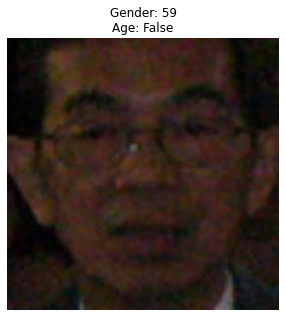

In [ ]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, gen, age = trn[0]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

In [ ]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.640	Mean: -0.403	dtype: torch.float32
Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 0.762	Mean: 0.345	dtype: torch.float32
Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 1.000	Mean: 0.438	dtype: torch.float32


In [ ]:
from torchvision import models
def get_model():
    model = models.vgg16(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    
    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

EPOCH: 1.000	trn_loss: 0.551	val_loss: 0.465	val_gender_acc: 0.834	val_age_mae: 6.238	(779.37s - 3117.47s remaining)
EPOCH: 2.000	trn_loss: 0.401	val_loss: 0.444	val_gender_acc: 0.847	val_age_mae: 6.229	(1555.70s - 2333.56s remaining)
EPOCH: 3.000	trn_loss: 0.284	val_loss: 0.493	val_gender_acc: 0.846	val_age_mae: 6.340	(2335.09s - 1556.73s remaining)
EPOCH: 4.000	trn_loss: 0.198	val_loss: 0.655	val_gender_acc: 0.842	val_age_mae: 6.339	(3110.83s - 777.71s remaining)
EPOCH: 4.994	val_loss: 0.375	val_gender_acc: 0.969	val_age_mae: 6.541	(3887.91s - 4.54s remaining)

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 6/6 [00:00<00:00, 291.40it/s]

EPOCH: 5.000	trn_loss: 0.157	val_loss: 0.733	val_gender_acc: 0.847	val_age_mae: 6.322	(3888.25s - 0.00s remaining)


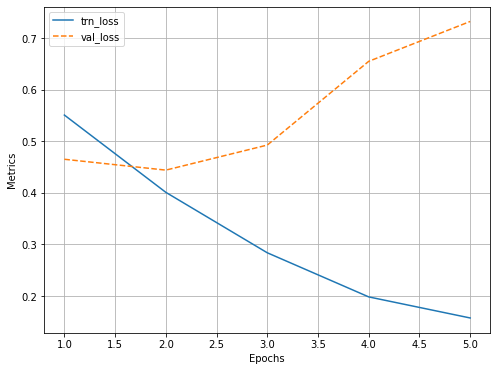

In [ ]:
model, criterion, optimizer = get_model()
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix==N: break
        total_loss = train_batch(data, model, optimizer, criterion)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')

    N = len(test_loader)
    for ix, data in enumerate(test_loader):
        if ix==N: break
        total_loss, gender_acc, age_mae = validate_batch(data, model, criterion)
        gender_acc /= len(data[0])
        age_mae /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss, val_gender_acc=gender_acc, val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

--2020-11-08 12:56:14--  https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6kzr8l68e9kpjkf/5_9.JPG [following]
--2020-11-08 12:56:14--  https://www.dropbox.com/s/raw/6kzr8l68e9kpjkf/5_9.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc177111820f4b375b4969ae95e7.dl.dropboxusercontent.com/cd/0/inline/BCx_9g_kyOTpcIFyCAe6R019q6zv2sreGAJzOnco0RygfRp0a253M-JC2VhM9pBdc9xj107QBfquDj3PkN8_exIM5Qnz4eSpipop6_K1f5IM8IC-5z2-zxEmkQUiSQRE-XM/file# [following]
--2020-11-08 12:56:14--  https://uc177111820f4b375b4969ae95e7.dl.dropboxusercontent.com/cd/0/inline/BCx_9g_kyOTpcIFyCAe6R019q6zv2sreGAJzOnco0RygfRp0a253M-JC2VhM9pBdc9xj107QBfquDj3PkN8_exIM5Qnz4eSpipop6_K1f5IM8IC-5z2-zxEmkQUiSQRE-

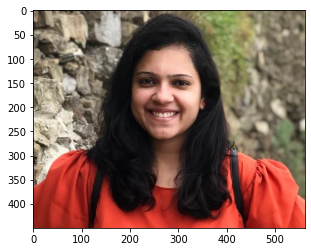

In [ ]:
!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
im = cv2.imread('/content/5_9.JPG')
im = trn.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
im = cv2.imread('/content/5_9.JPG')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))